# Recycling Images Model 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from io import BytesIO
import os

import hashlib
from fastai.vision import *
from fastai.vision import image as im
from fastai.metrics import accuracy
from PIL import Image
import requests

In [3]:
np.random.seed(42)

bs = 64  # can go lower if out of GPU memory

## Looking at the data

In [4]:
image_path = Path('/home/ubuntu/images')

In [5]:
file_names = get_image_files(image_path)
len(file_names)

2197

In [6]:
verify_images(path=image_path,
              delete=True,
              ext='jpg')

In [7]:
file_names = get_image_files(image_path)
len(file_names)

2197

In [8]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()


duplicates = list()
hash_keys = dict()
for index, filename in enumerate(file_names):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))


print(f'Deleting {len(duplicates)} duplicate images.')
for index in duplicates:
    os.remove(file_names[index[0]])

Deleting 0 duplicate images.


In [9]:
file_names = get_image_files(image_path)
len(file_names)

2197

In [10]:
reg_ex_pat = r'/([^/]+)_\d+.jpg$'

In [11]:
transforms = get_transforms(do_flip=True,
                            flip_vert=True,
                            max_rotate=10.0,
                            max_zoom=1.2,
                            max_lighting=0.5,
                            max_warp=0.35,
                            p_affine=0.8,
                            p_lighting=0.75)

In [12]:
data = ImageDataBunch.from_name_re(image_path,
                                   file_names,
                                   reg_ex_pat,
                                   ds_tfms=transforms,
                                   size=224,
                                   bs=bs
                                   ).normalize(imagenet_stats)

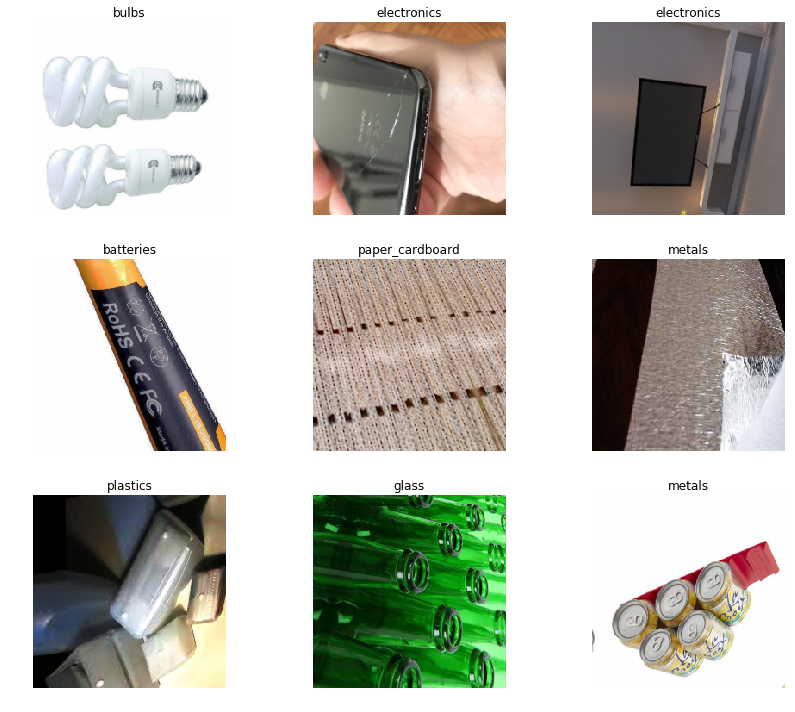

In [13]:
data.show_batch(rows=3, figsize=(12,10))

In [14]:
assert len(data.classes) == data.c
data.classes

['batteries',
 'bulbs',
 'electronics',
 'glass',
 'metals',
 'paper_cardboard',
 'plastics']

## Training: resnet50

In [17]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.186329,0.250781,0.917995,00:57
1,0.763275,0.257235,0.931663,00:59
2,0.563720,0.183044,0.945330,00:58
3,0.440927,0.190278,0.943052,00:56


In [19]:
learn.save('stage-1')

## Results

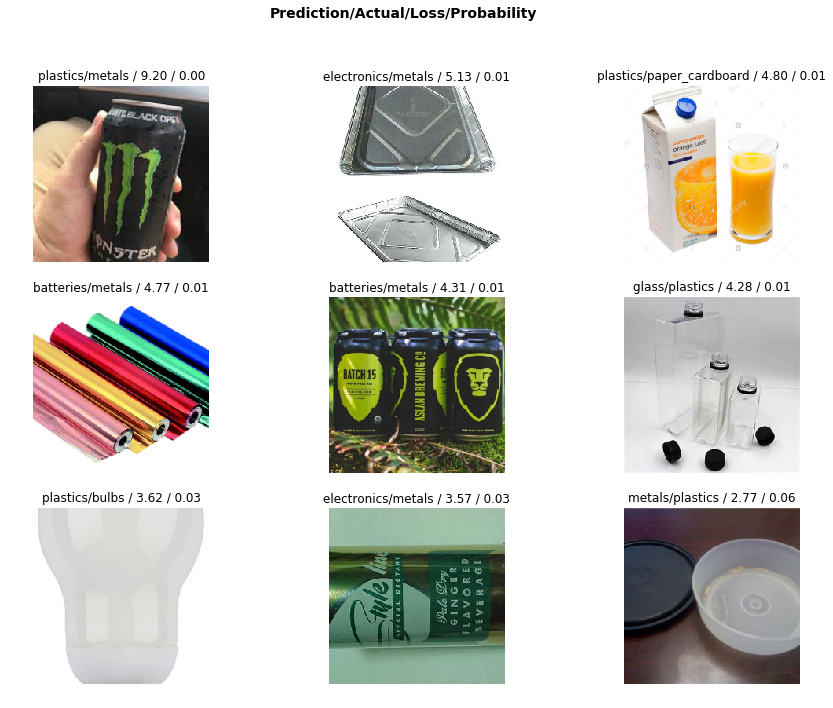

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

assert len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

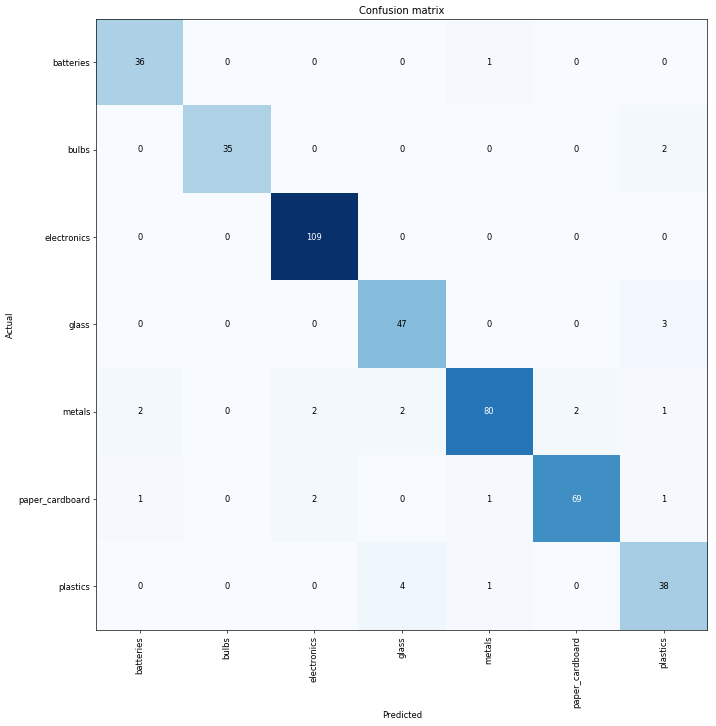

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('plastics', 'glass', 4),
 ('glass', 'plastics', 3),
 ('bulbs', 'plastics', 2),
 ('metals', 'batteries', 2),
 ('metals', 'electronics', 2),
 ('metals', 'glass', 2),
 ('metals', 'paper_cardboard', 2),
 ('paper_cardboard', 'electronics', 2)]

## Unfreezing, fine-tuning, and learning rates

In [23]:
learn.load('stage-1');

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.63E-06


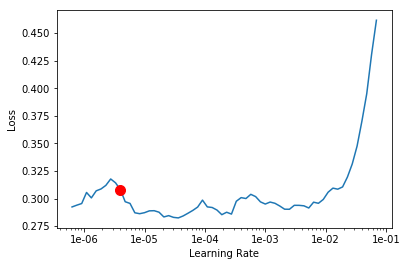

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-5, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.276778,0.171611,0.954442,01:00
1,0.269780,0.169168,0.949886,00:59


## Prediction Time? 

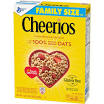

('paper_cardboard', 0.999980092048645)

In [65]:
test_image = im.open_image('/home/ubuntu/images/paper_cardboard_2.jpg')
display(test_image)

pred_class, _, pred_probs = learn.predict(test_image)
pred_class.obj, max(pred_probs.tolist())

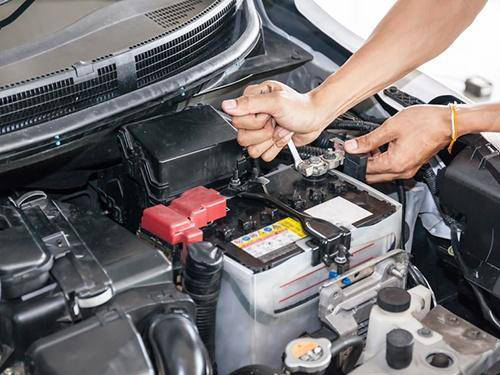

('batteries', 0.9726997017860413)

In [85]:
url = 'https://www.theflyer.com/uploads/image/205186801_205186900/automotive-battery-delivery-and-installation-service-we-replace-batteries-on-the-spot-205186880_c2747deefa5268fc_858X617.jpg'

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
display(image_from_interwebs)

pred_class, _, pred_probs = learn.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())

Enter image URL: https://cdn.shopify.com/s/files/1/0102/3472/products/paper-towels-plain_0669f160-aed5-4d49-847c-ca9617327128_1024x1024.jpg?v=1450824133
--------------
Image:


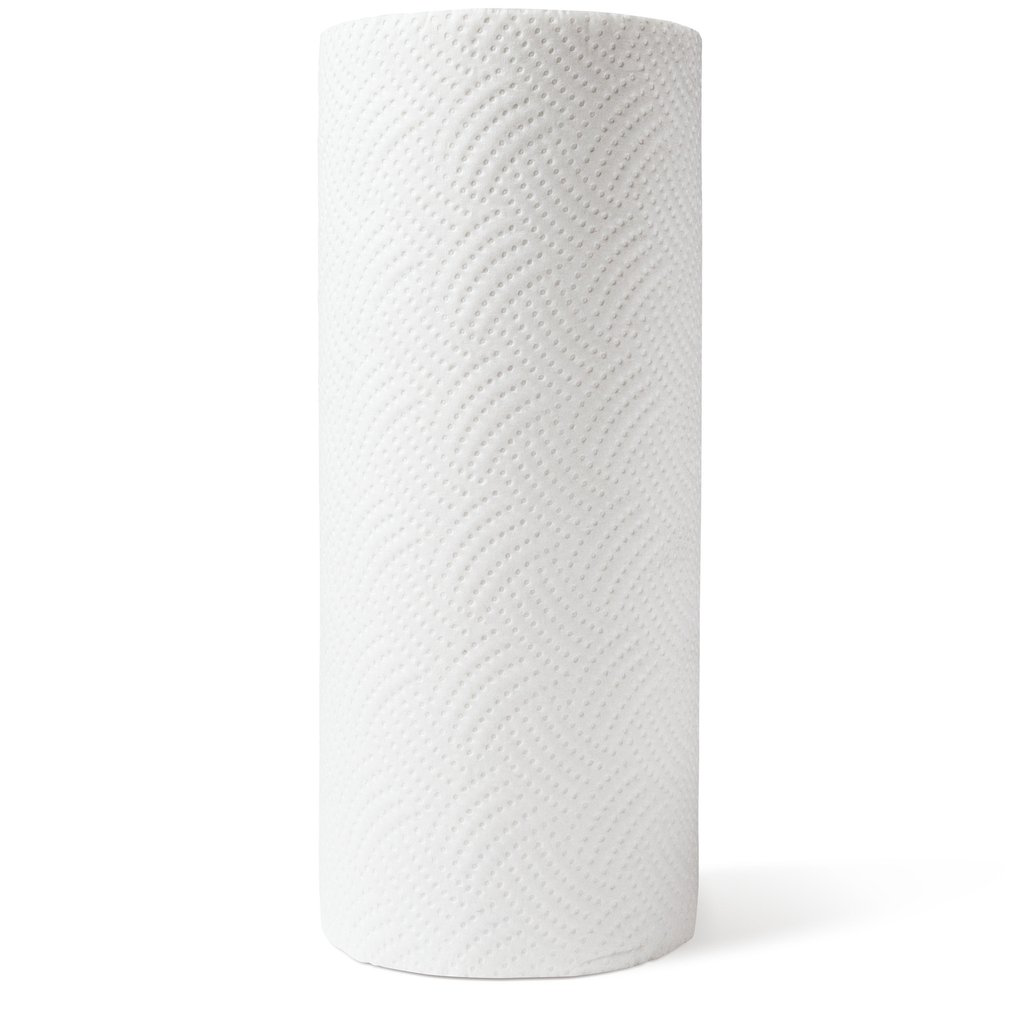

--------------
Predicted Class:         metals
Predicted Probability:   0.9577525854110718
Time to make prediction: 0.04657s


In [73]:
## INTERACTIVE MODE
url = input('Enter image URL: ')

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
print('--------------')
print('Image:')
display(image_from_interwebs)
print('--------------')
start_time = time.time()
pred_class, _, pred_probs = learn.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())
print(f'Predicted Class:         {pred_class.obj}')
print(f'Predicted Probability:   {max(pred_probs.tolist())}')
print(f'Time to make prediction: {round(time.time() - start_time, 5)}s')

## Save Model Time 

In [82]:
learn.export('/home/ubuntu/model_1020_0320.pkl')

In [83]:
learner_2 = load_learner('/home/ubuntu/', file='model_1020_0320.pkl')

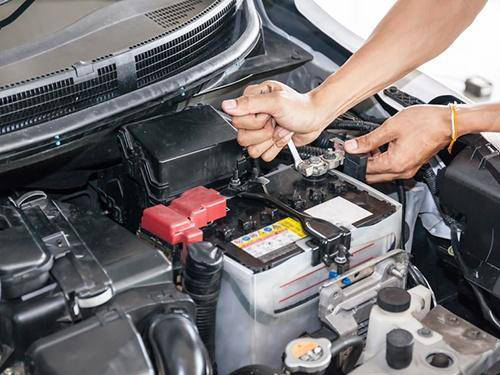

('batteries', 0.9726997017860413)

In [84]:
url = 'https://www.theflyer.com/uploads/image/205186801_205186900/automotive-battery-delivery-and-installation-service-we-replace-batteries-on-the-spot-205186880_c2747deefa5268fc_858X617.jpg'

response = requests.get(url)
image_from_interwebs = im.open_image(BytesIO(response.content))
display(image_from_interwebs)

pred_class, _, pred_probs = learner_2.predict(image_from_interwebs)
pred_class.obj, max(pred_probs.tolist())

----- 